In [2]:
library(ggplot2)
library(igraph)
library(dplyr)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Generate a scale free network
N <- 100
m <- 2
g <- barabasi.game(N, m, directed = FALSE)
g <- erdos.renyi.game(N, 0.3, directed = FALSE)

# Assign the critical threshold to each node
V(g)$z_c <- degree(g)

# Assign the initial state to each node
V(g)$z <- 0

Note that you can implement the toppling using either recursion or iteration. Recursion might be more elegant, but depth limit can be a constraint.

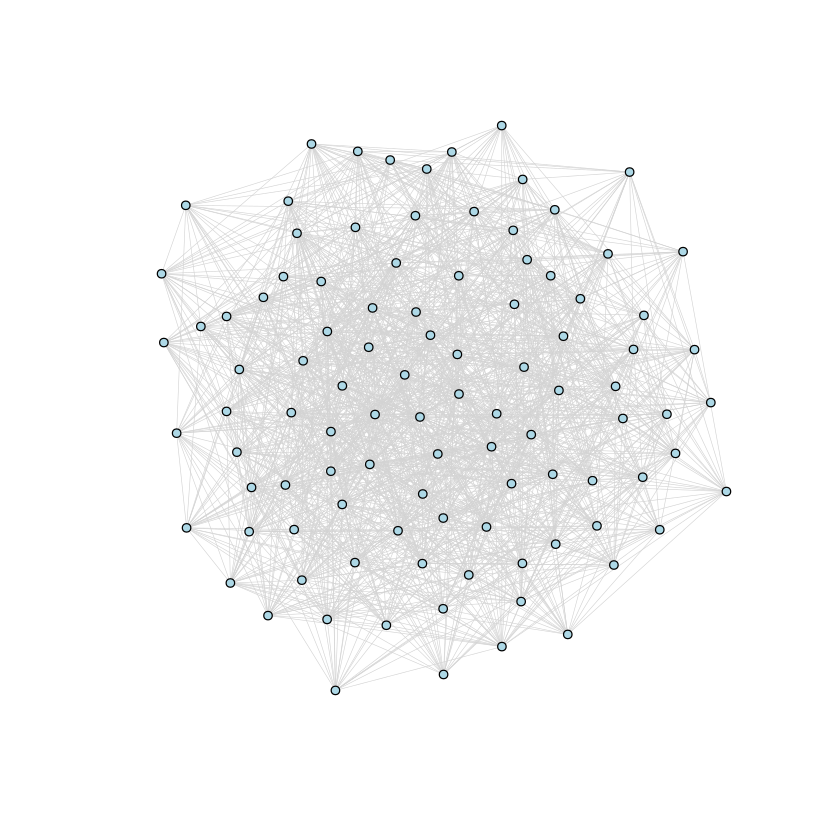

In [4]:
plot(g, 
     vertex.size = 3,
     vertex.label = NA,
     vertex.color = "lightblue",
     edge.width = 0.5,
     edge.color = "lightgray",
     layout = layout_with_fr(g, niter = 500))

In [5]:
f <- 1 / N

print(degree(g))

for (i in 1:100000){ # Shold be a stopping condition
  unstable_queue <- c()

  # Sample a node
  node <- sample(N, 1)

  print(paste("Sampled node", node))
  flush.console()

  # Update the state of the node
  V(g)[node]$z <- V(g)[node]$z + 1

  # Check if the node has become unstable
  if (V(g)[node]$z >= V(g)[node]$z_c){
    print(paste("Node", node, "is unstable"))
    flush.console()
    unstable_queue <- c(node)
  }

  #print(V(g)$z)
  #flush.console()

  if (length(unstable_queue) > 0){
    print("Starting avalanche")
    print("")
  }
  

  # Solve unstable queue
  S <- c() # Avalanche size
  T <- 0 # Avalanche duration
  G <- 0 # Toppled grains
  while (length(unstable_queue) > 0){
    # Pick the first node in the queue
    node <- unstable_queue[1]
    S <- c(S, node)
    T <- T + 1

    # Remove the node from the queue
    unstable_queue <- unstable_queue[-1]

    # Get the neighbors of the node
    neighbors <- neighbors(g, node)
    
    # Sample a fraction of the neighbors
    to_keep <- runif(length(neighbors)) < 1-f

    print(paste("Neighbors", neighbors, " to keep", neighbors[to_keep]))
    flush.console()

    neighbors <- neighbors[to_keep]
    G <- G + length(neighbors)
    
    # Update the state of the neighbors
    V(g)[neighbors]$z <- V(g)[neighbors]$z + 1

    # Update the state of the node
    V(g)[node]$z <- 0

    # Check if the neighbors have become unstable
    unstable_neighbors <- neighbors[V(g)[neighbors]$z >= V(g)[neighbors]$z_c]


    if (length(unstable_neighbors) > 0){
      print(paste("Unstable neighbors", unstable_neighbors))
      flush.console()

      unstable_queue <- c(unstable_queue, unstable_neighbors)
    }


  } # End of while loop

  A <- unique(S)
  if (length(S) > 0){
    sprintf("Avalanche size: %d, Avalanche duration: %d, Toppled grains: %d", length(S), T, G)
  }

  #print(V(g)$z)
  #flush.console()


} # End of for loop

ERROR: Error in parse(text = x, srcfile = src): <text>:70:7: unexpected symbol
69:       print(paste("Unstable neighbors", unstable_neighbors)
70:       flush.console
          ^


In [63]:
a <- c(4)
a <- c(a, 5)
a <- c(a, 4)
a


[1] 4 5 4

In [86]:
V(g)$z <- 0
V(g)$z[1] <- 4
V(g)$z

[1] 4 0 0 0 0 0 0 0 0 0

In [87]:
a <- c(V(g)[V(g)$z > 3])
a

+ 1/10 vertex, from 173e172:
[1] 1